# CS 591 S1 -- Summer 1, 2020 -- HW 03


### Due date: Due Monday, June 29th, @ midnight in GradeScope with 2 day grace period

Please discuss with Ellisson and me via a private message on Piazza if there is some
issue which prevents you from meeting the deadline. The deadline is not a big deal, but
you need to work on your project, so getting this done sooner rather than later is a good idea.  It is about half as much work as the previous homeworks: lots of read and think about but not ALL that much coding. 


### General Instructions

Please complete this notebook by filling in solutions where indicated. Be sure to "Run All" from the Cell menu before submitting. 

 
 

In [1]:
# General useful imports
import array as ar
import contextlib
import wave
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
import scipy.io.wavfile as wf

from numpy import arange,linspace,mean, var, std, corrcoef, cov, transpose, ones,log,pi, sin, cos, exp, abs, angle, convolve, floor
from numpy.random import random, randint, uniform
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab

from math import sqrt

%matplotlib inline

# Basic parameters for reading and writing mono wave files

numChannels   = 1                      # mono
sampleWidth   = 2                      # in bytes, a 16-bit short
SR            = 44100                  #  sample rate
MAX_AMP       = (2**(8*sampleWidth - 1) - 1)    #maximum amplitude is 2**15 - 1  = 32767
MIN_AMP       = -(2**(8*sampleWidth - 1))       #min amp is -2**15
windowWidth   = 4410
windowSlide   = 2205


def round4(x):
    return np.around(x,4)

def round2(x):
    return np.around(x,2)

# Basic Numpy statistical functions

X = np.array([1,2,3])       # just an example
Y = np.array([4,5,6])
             
# mean of a list
mean(X)                            

# Clip a signal or a scalar to upper and lower bounds, if not specified, us
# bounds provided above; will change the array in place and return it.
# Does NOT make a new copy. 

def clip(X,lb=MIN_AMP,ub=MAX_AMP):
    
    if type(X) != list and type(X) != np.ndarray:
        return max(min(X,MAX_AMP),MIN_AMP)
    
    for k in range(len(X)):
        X[k] = max(min(X[k],MAX_AMP),MIN_AMP)
    return X

# To prevent clipping, this function takes a signal and rescales the amplitude
# (which must be given in relative units, in range 0 .. 1) so that 
#
#           max(X) = A * MAX_AMP
#

def scaleSignal(X,A=1.0):
        s = MAX_AMP*A/max(X)
        return np.array( [ x*s for x in X ] ).astype(int)

    
# create a signal from a spectrum represented as triples (freq,amp,phase)
# mode = 'absolute' (amplitude in spectrum is in range MIN_AMP .. MAX_AMP)
#      = 'relative' (amplitude in spectrum is in range 0 .. 1)
# if amp != None, will be resca

def makeSignal(S=[(220,1,0)], mode = 'relative', amp=None, duration=1):
    X = np.zeros(int(SR*duration)) 
    T = np.arange(int(SR*duration))
    if mode == 'relative':
        for (f,A,phi) in S:         
            X += MAX_AMP * A * np.sin( 2 * pi * f * T / SR + phi ) 
    else: # mode == 'relative'
        for (f,A,phi) in S:         
            X +=  A * np.sin( 2 * pi * f * T / SR + phi ) 
    if amp == None:
        return X.astype(int) 
    else:
        return (((X * MAX_AMP)/ max(X)) * amp).astype(int) 

# Some sample spectra
    
def makeSpectrum(instr,freq=220):
    if(instr=="triangle"):
        return ([(freq,1.0,0.0),    
        (freq*3,-1/(9),0.0), 
        (freq*5,1/(25),0.0), 
        (freq*7,-1/(49),0.0), 
        (freq*9,1/(81),0.0), 
        (freq*11,-1/(121),0.0), 
        (freq*13,1/(13*13),0.0)])
    elif(instr=="square"):
        return ([(freq,2/(np.pi),0.0), 
        (freq*3,2/(3*np.pi),0.0), 
        (freq*5,2/(5*np.pi),0.0), 
        (freq*7,2/(7*np.pi),0.0), 
        (freq*9,2/(9*np.pi),0.0), 
        (freq*11,2/(11*np.pi),0.0), 
        (freq*13,2/(13*np.pi),0.0),
        (freq*15,2/(15*np.pi),0.0),
        (freq*17,2/(17*np.pi),0.0),
        (freq*19,2/(19*np.pi),0.0),
        (freq*21,2/(21*np.pi),0.0)])
    elif(instr=="clarinet"):
        return ([(freq,0.314,0.0), 
        (freq*3,.236,0.0), 
        (freq*5,0.157,0.0), 
        (freq*7,0.044,0.0), 
        (freq*9,0.157,0.0), 
        (freq*11,0.038,0.0), 
        (freq*13,0.053,0.0)] ) 
    elif(instr=="bell"):
        return ([(freq,0.1666,0.0), 
        (freq*2,0.1666,0.0), 
        (freq*3,0.1666,0.0), 
        (freq*4.2,0.1666,0.0), 
        (freq*5.4,0.1666,0.0), 
        (freq*6.8,0.1666,0.0)])  
    elif(instr=="steelstring"):
        return ([(freq*0.7272, .00278,0.0),
        (freq, .0598,0.0),
        (freq*2, .2554,0.0),
        (freq*3, .0685,0.0),
        (freq*4, .0029,0.0),
        (freq*5, .0126,0.0),
        (freq*6, .0154,0.0),
        (freq*7, .0066,0.0),
        (freq*8, .0033,0.0),
        (freq*11.0455, .0029,0.0),
        (freq*12.0455, .0094,0.0),
        (freq*13.0455, .0010,0.0),
        (freq*14.0455, .0106,0.0),
        (freq*15.0455, .0038,0.0)])
    elif(instr=='organ'):
        return ([(freq*1, 0.16042589643241895, 0.0),
        (freq*2, 0.1655, 0.0),
        (freq*3, 0.0015, 0.0),
        (freq*3.9949, 0.02161, 0.0),
        (freq*5.9949, 0.04552, 0.0),
        (freq*7.9949, 0.0324, 0.0),
        (freq*9.9899, 0.00242, 0.0),
        (freq*11.9898, 0.0045, 0.0),
        (freq*17.9847, 0.0057, 0.0),
        (freq*19.9796, 0.0011, 0.0),
        (freq*27.9745, 0.0008, 0.0),
        (freq*29.9745, 0.0016, 0.0)]        
        )
    else:
        return []

# Piano key frequencies

notenames = ['A0', 'Bb0', 'B0', 'C1', 'C#1', 'D1', 'Eb1', 'E1', 'F1', 'F#1',
       'G1', 'Ab1', 'A1', 'Bb1', 'B1', 'C2', 'C#2', 'D2', 'Eb2', 'E2',
       'F2', 'F#2', 'G2', 'Ab2', 'A2', 'Bb2', 'B2', 'C3', 'C#3', 'D3',
       'Eb3', 'E3', 'F3', 'F#3', 'G3', 'Ab3', 'A3', 'Bb3', 'B3', 'C4',
       'C#4', 'D4', 'Eb4', 'E4', 'F4', 'F#4', 'G4', 'Ab4', 'A4', 'Bb4',
       'B4', 'C5', 'C#5', 'D5', 'Eb5', 'E5', 'F5', 'F#5', 'G5', 'Ab5',
       'A5', 'Bb5', 'B5', 'C6', 'C#6', 'D6', 'Eb6', 'E6', 'F6', 'F#6',
       'G6', 'Ab6', 'A6', 'Bb6', 'B6', 'C7', 'C#7', 'D7', 'Eb7', 'E7',
       'F7', 'F#7', 'G7', 'Ab7', 'A7', 'Bb7', 'B7', 'C8', 'R']

# Create chromatic scale, e.g., as on the piano, as a dictionary    

Freqs = {} 

f = 27.5

for name in notenames:
    Freqs[name] = f
    f *= 2**(1/12)

Freqs['R'] = 0                    # a rest (silence) 

# test

Freqs['C4']

261.62556530059896

In [2]:
# I/O for Wave files

# Read a mono wave file from a local file and return the entire file as a 1-D numpy array

def readWaveFile(infile,withParams=False,asNumpy=True):
    with contextlib.closing(wave.open(infile)) as f:
        params = f.getparams()
        frames = f.readframes(params[3])
        if(params[0] != 1):
            print("Warning in reading file: must be a mono file!")
        if(params[1] != 2):
            print("Warning in reading file: must be 16-bit sample type!")
        if(params[2] != 44100):
            print("Warning in reading file: must be 44100 sample rate!")
    if asNumpy:
        X = ar.array('h', frames)
        X = np.array(X,dtype='int16')
    else:  
        X = array.array('h', frames)
    if withParams:
        return X,params
    else:
        return X

# Write out an array as a wave file to the local directory
        
def writeWaveFile(X,fname):
    X = clip(X)
    params = [1,2, SR , len(X), "NONE", None]
    data = ar.array("h",X)
    with contextlib.closing(wave.open(fname, "w")) as f:
        f.setparams(params)
        f.writeframes(data.tobytes())
    print(fname + " written.")

In [3]:
# Read a stereo wave file from a local file and return the entire file as a 2-D numpy array
# These read or write a stereo file

# Thanks to Elisson for these

def readWaveFileStereo(infile):
    rate, data = wf.read(infile)
    return np.array([data[:,0], data[:,1]])

def writeWaveFileStereo(filename, data, rate=SR, ):
    dataAlt = (data.T).astype(np.int16)
    wf.write(filename, rate, data.T)

In [4]:
# Display a graph of a signal

def displaySignal(X, left = 0, right = -1, minAmp=-1.2, maxAmp=1.2,title='Signal Window for X',signalRelative=False,xUnits = "Seconds", yUnits = "Relative",width=12, height=4):
    
    if(signalRelative):
        X = [x*MAX_AMP for x in X]
    minAmplitude = -(2**15 + 100)        # just to improve visibility of curve
    maxAmplitude = 2**15 + 300    
    
    if(xUnits == "Samples"):
        if(right == -1):
            right = len(X)
        T = range(left,right)
        Y = X[left:right]
    elif(xUnits == "Seconds"):
        if(right == -1):
            right = len(X)/44100
        T = np.arange(left, right, 1/44100)
        leftSampleNum = int(left*44100)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    elif(xUnits == "Milliseconds"):
        if(right == -1):
            right = len(X)/44.1
        T = np.arange(left, right, 1/44.1)
        leftSampleNum = int(left*44.1)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    else:
        print("Illegal value for xUnits")
        
    if(yUnits == "Relative"):
        minAmplitude = minAmp            # just to improve visibility of curve
        maxAmplitude = maxAmp
        Y = [x/32767 for x in Y]

    fig = plt.figure(figsize=(width,height))   # Set x and y dimensions of window: may need to redo for your display
    fig.suptitle(title, fontsize=14, fontweight='bold')
    ax = plt.axes()
    if(xUnits=="Samples"):
        ax.set_xlabel("Sample Number")
    else:
        ax.set_xlabel(xUnits)
    ax.set_ylabel(yUnits + ' Amplitude')
    ax.set_ylim([minAmplitude,maxAmplitude])
    ax.set_xlim([left, right])
    plt.axhline(0, color='black')      # draw the 0 line in black
    plt.plot(T,Y) 
    if(    (xUnits == "Samples" and (right - left) < 101)
        or (xUnits == "Seconds" and (right - left) < 0.001)
        or (xUnits == "Milliseconds" and (right - left) < 1) ):
            plt.plot(T,Y, 'ro')                     
    plt.grid(True)                     # if you want dotted grid lines
    plt.show()
    
f = 10
T = np.arange(SR*1)
X = MAX_AMP * np.sin(2*pi*f*T/SR)

# displaySignal(X)


###  Displaying Spectra

Matplotlib has a useful function to display spectra:

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html

The term "magnitude spectrum" refers to the fact that we are interested in magnitude
of the various frequencies which make up the signal, instead of the power spectrum (square of the magnitudes) or the phase spectrum (what the phase of the various frequency components are). 



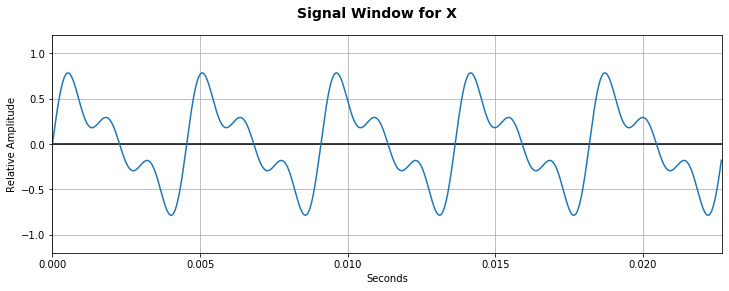

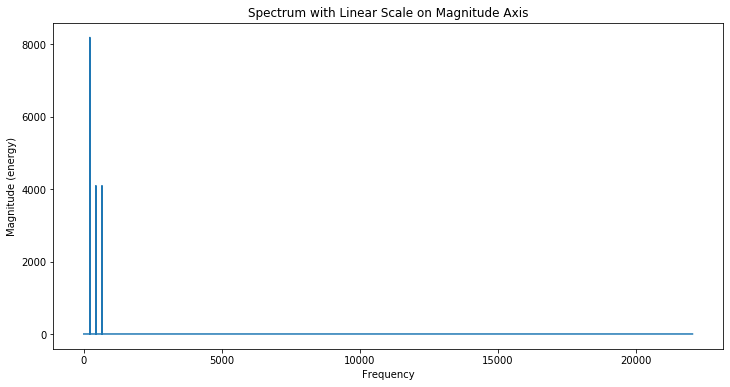

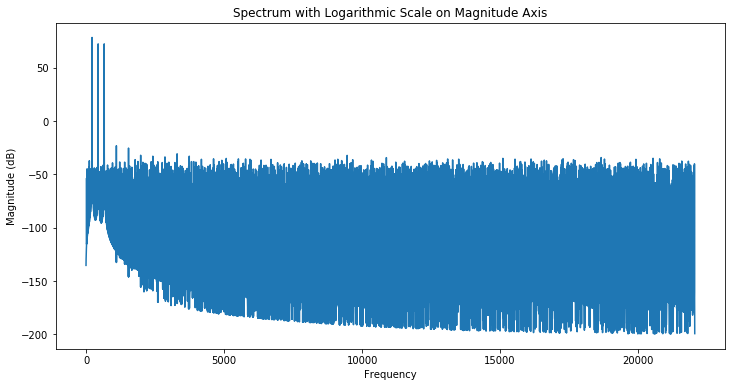

In [6]:
X = makeSignal([(220,0.5,0),(440,0.25,0.0),(660,0.25,0.0)])
displaySignal(X[:1000])

plt.figure(figsize=(12,6))
plt.title("Spectrum with Linear Scale on Magnitude Axis")
plt.magnitude_spectrum(X,SR)
plt.show()

plt.figure(figsize=(12,6))
plt.title("Spectrum with Logarithmic Scale on Magnitude Axis")
plt.magnitude_spectrum(X,SR,scale='dB')
plt.show()

### Calculating Spectra using the Fast-Fourier Transform

0.008346313740813084
0.02337273986132163
0.009114262574577084
22051


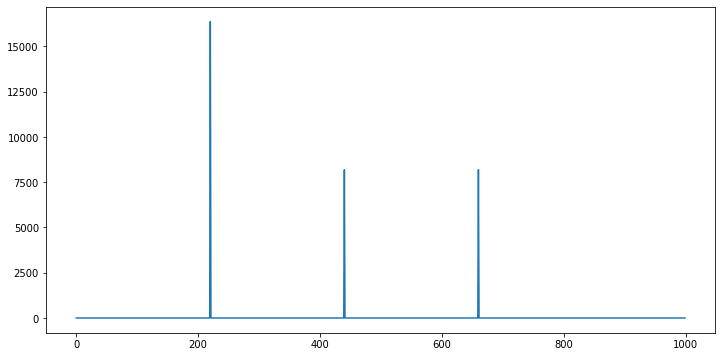

In [7]:

def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X)
       
# return the phase spectrum

def phaseFFT(X):
    return [np.angle(x) for x in np.fft.rfft(X)]
    
# return fft coefficients in polar form

def polarFFT(X):
    return [(abs(2*x/len(X)), np.angle(2*x/len(X))) for x in np.fft.rfft(X)]

# We can also return a list of triples of form  (f, A, phi) for each frequency
# f detected by the transform
    
def spectrumFFT(X):
    R = np.fft.rfft(X)
    return [ ( k*44100/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k]) ) for k in range(len(R)) ]

# S = spectrumFFT(X)
# S[990:1010]

X = makeSignal([(220,0.5,0),(440,0.25,0.0),(660,0.25,0.0)])

S = realFFT(X)

print(S[1000])
print(S[3000])
print(S[5000])

print(len(S))

plt.figure(figsize=(12,6))
plt.plot(S[:1000])
plt.show()

### Displaying Spectrograms

To display spectrograms (spectra over time), we use `specgram`:

https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.specgram.htm

There are a number of parameters of interest:

- `NFFT`  (int)  is the number of data points used in each block for the FFT. A power 2 is most efficient. The default value is 256. 

- `noverlap` (int) is the number of points of overlap between blocks. The default value is 128.

- `mode` can be used to set the values plotted on the amplitude (Y) axis:
   - `magnitude`  is  the amplitude of the sine wave in the signal
   - `psd` is the power, i.e., the amplitude squared
   - The default is `psd`, which corresponds to our human perception of loudness.


- `scale`  determines the scaling on the Y axis, either
   - `linear` or 
   - `dB` for a logarithmic scale in decibels; 
   - `default` is `dB` if `mode` is `psd` or `magnitude`,  and `linear` otherwise. 



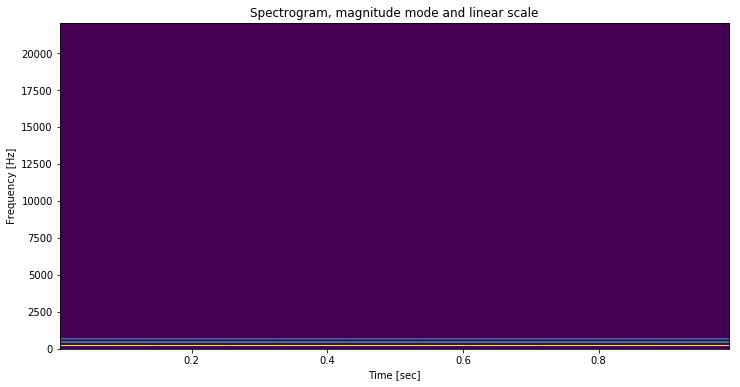

In [7]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram, magnitude mode and linear scale')
plt.specgram(X, NFFT=1024,noverlap=512,Fs=SR,mode='magnitude',scale='linear')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
# Audio(X,rate=SR)

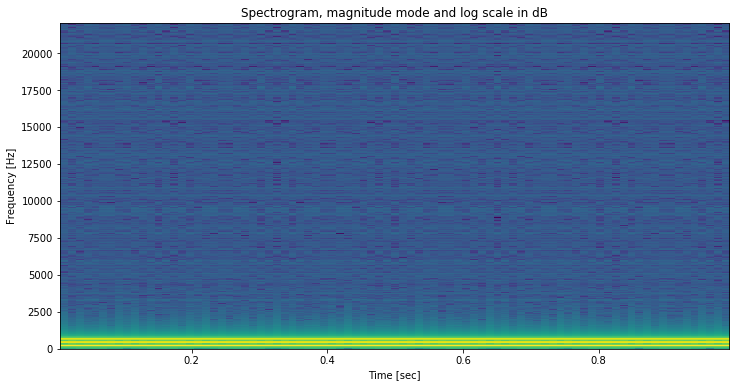

In [8]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram, magnitude mode and log scale in dB')
plt.specgram(X, NFFT=1024,noverlap=512,Fs=SR,mode='magnitude',scale='dB')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

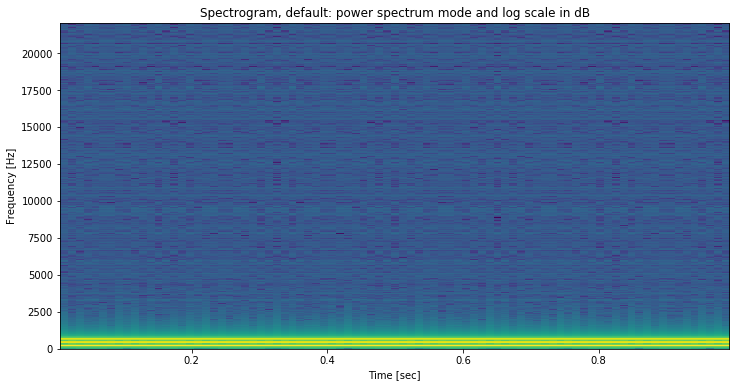

In [9]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram, default: power spectrum mode and log scale in dB')
# plt.specgram(X, NFFT=1024,noverlap=512,Fs=SR,mode='psd',scale='dB')
plt.specgram(X, NFFT=1024,noverlap=512,Fs=SR)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

##  Problem One (Autocorrelation)


### Correlation 

The correlation of two sequences of length $N$ is exactly the same as if we consider them to be equiprobable, finite random variables:

$$corr(X,Y)\,=\, {Cov(X,Y)\over \sigma_X\cdot \sigma_Y} \,
             =\,{E[(X-\mu_X)\cdot (Y-\mu_Y)]\over\sigma_X\cdot \sigma_Y}
             =\,E\left[{X-\mu_X\over\sigma_X} \cdot {Y-\mu_Y\over\sigma_Y}\right]
             \,=\, E[Z_X\cdot Z_Y] \,=\,  {Z_X @ Z_Y\over N}$$

where $@$ represents the dot product of the two standardized signals. 

Since we are looking for the maximum of the correlation, we do not mathematically speaking need
to standardize, however, to prevent arithmetic overflow with large numbers, generallly we need
to normalize the signals.  We may therefore use approximations to the mean and standard deviation,
which for a simple sine wave $X$ are $\mu_X = 0.0$ and $\sigma_X = {1\over \sqrt 2} = 0.707.$

In our context, with wave files, we will use 

$$\sigma_X \, =\,  {\text{MAX_AMP}\over \sqrt 2} \, =\, 3169.7679$$ 


This is about 5x faster than using full standardization and works just as well!


### Part (A)

Complete the following code template to calculate $corr(X,Y)$, where we assume that $X$ and $Y$ are two signals of the same length. 

In [6]:


def corr(X,Y,normalize=True):    
    N = len(X)
    ret = 0
    if normalize:
        stddev = MAX_AMP / sqrt(2) #calculate std dev
        normX = X / stddev      #normalize
        normY = Y / stddev      #normalize 
        dotprod = normX @ normY   
        ret = dotprod / N
        return ret          # your code here
    else:
        dotprod = X @ Y
        ret = dotprod / N
        return ret          # your code here

# test

X = makeSignal()
X1 = X * 0.34
Y = -1 * X

print(corr(X,X))    # should be close to 1.0
print(corr(X,X1))   # should be close to 0.34
print(corr(X,Y))    # should be close to -1.0
print(corr(X1,Y))   # should be close to -0.34

print(corr(X,X,normalize=False))    # should be close to 536816844.60861677

print(  corr(X,X1,normalize=False) / corr(X,X,normalize=False))    # should be close to 0.34

0.9999603234390076
0.33998650996926266
-0.9999603234390076
-0.33998650996926266
536816844.60861677
0.33999999999999997


### Autocorrelation

When we correlate a signal with a delayed or lagged version of itself, we have the `autocorrelation` of
a signal. 
 

The *autocorrelation at lag k* of a signal $X$ of length $N$ at lag $k$ (a sample number) is the correlation of `X[:N-k]` with `X[k:]`:

$$acorrK(X,k)\, =\, {X[0]*X[k]  +  X[1]*X[k+1]  +    ...    +  X[N-k-1]*X[N-1]\over N}\,=\, {X[:N-k] @ X[k:]\over N}$$

           
as illustrated here:

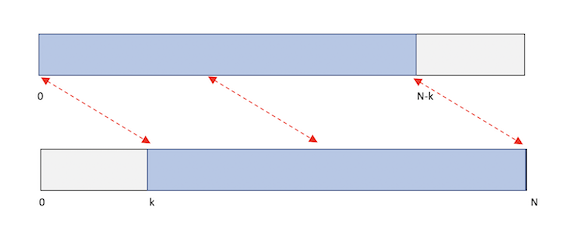

The *autocorrelation* of a signal $X$ of length $N$ is the signal consisting of lags from 0 to $\lfloor N/2\rfloor$:

$$acorr(X)\, =\, [\,  acorrK(X,0), \,acorrK(X,1), \,\ldots \, , \,acorrK(X,\lfloor N/2\rfloor) \,].$$

        


As explored in lecture, when a signal is periodic, then the autocorrelation will have maximum values (form *peaks*)
when the lag $k$ is at an integer multiple of the period; the first peak will (hopefully) provide the fundamental frequency of the signal. 


Note on efficiency:  As noted above, we must generally normalize the signals to prevent arithmetic overflow when multiplying large amplitudes; I've tested this, and it is about 5x faster to normalize with an approximate standard deviation (and assuming the mean is 0.0). However, *we should perform such normalization once at the beginning, and not redo it at every value of $k$ in the formula above.* 

### Part (B)

Complete the follow template to create the autocorrelation of a signal at lag $k$. Be sure to pay attention to the advice in italics in the previous paragraph. 

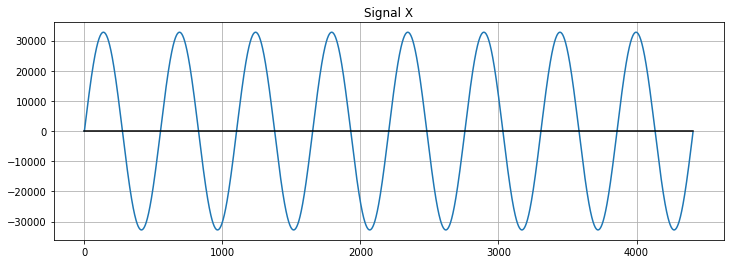

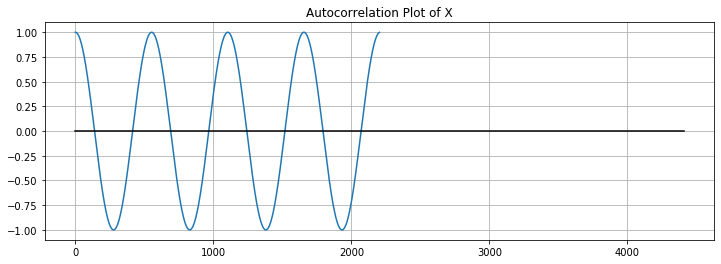

In [7]:
def acorrK(X,k,normalize=True):
    N = len(X)
    
    ret = 0
    
    if normalize: 
        stddev = MAX_AMP / sqrt(2)
        ZX = (X  - 0.0) / 23169.7679 
        dotprod = ZX[:N - k] @ ZX[k:]
        ret = dotprod / ( N - k)
        
    else:
        
        dotprod = X[:N - k] @ X[k:]
        ret = dotprod / (N - k)
        
        
    return ret          # your code here



def acorr(X,normalize=True):
    N = len(X)
    
    lim = int(floor(N / 2))
    
    T = np.ones(lim)
   
    
    
    if normalize:
        stddev = MAX_AMP / sqrt(2)
        ZX = np.array(X)  / 23169.7679   #normalize X
        retSig = [acorrK(ZX, k, normalize = False) for k in np.arange(len(T))]
        
    else:
        
        retSig = [acorrK(X, k, normalize = False) for k in np.arange(len(T))]
    
    
    return  retSig         # your code here

# test

X = makeSignal([(80,1,0)],duration=0.1)

A = acorr(X)

plt.figure(figsize=(12,4))
plt.title("Signal X")
plt.plot(X)
plt.plot([0,len(X)],[0,0],color='k')
plt.grid()
plt.show()

plt.figure(figsize=(12,4))
plt.title("Autocorrelation Plot of X")
plt.plot(A)
plt.plot([0,len(X)],[0,0],color='k')
plt.grid()
plt.show()

### Finding Peaks

We will use the function from HW 02 to find the peaks in the autocorrelation plot. 

Hint: Due to boundary conditions, the first couple of values in the plot may
give false positives (look like peaks); since we can not detect frequencies above the
Nyquist Limit, you should start to look for peaks starting at index 3 in the autocorrelation
(0 would be the same signal, 1 would indicate a frequency of 44.1 kHz, and 2 would indicate
a frequency of 22.05 kHz = the Nyquist Limit). 

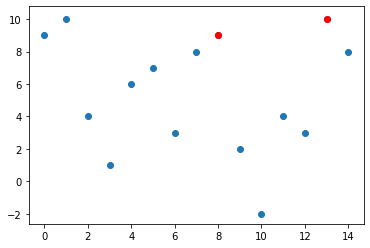

In [10]:
def find_peaks(A,relative_threshold=0.75): 
    absolute_threshold = relative_threshold * max(A)    # or could assume highest value is at A[0]    
    peaks = []
    for t in range(3,len(A)-1):             
        if A[t-1] < A[t] and A[t] > A[t+1] and A[t] > absolute_threshold:
            peaks.append(t)
    return np.array(peaks)
             
L = [9,10,4,1,6,7,3,8,9,2,-2,4,3,10,8]     

# test 

Px = find_peaks(L,0.8)
Py = [ L[x] for x in Px ]


plt.scatter(range(len(L)),L)
plt.scatter(Px,Py,color='r')
plt.show()

### Part (C)

Complete the following template to create autocorrelation plots with identified peaks in red, as in the
previous example. 

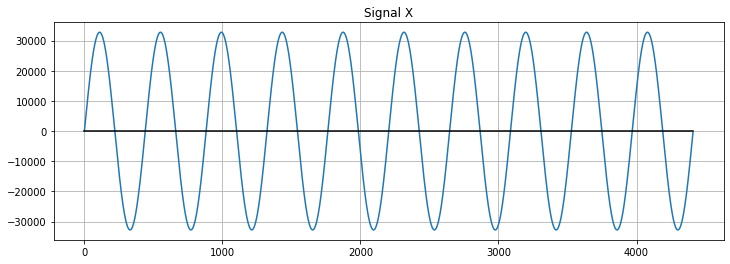

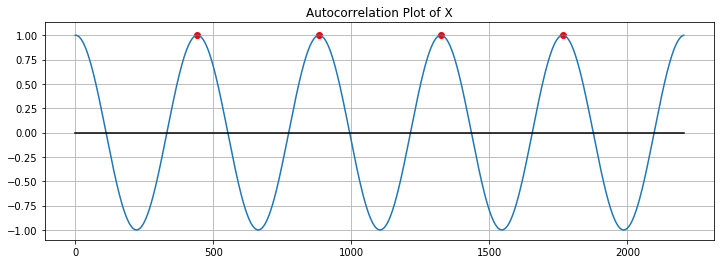

[ 442  883 1325 1766] [1.000111135532469, 1.0001426420421098, 1.000202842727779, 1.0003109478820211]


In [59]:
def acorr_plot(X,relativeThreshold = 0.75, display=True):
    
    A = acorr(X, normalize = True)
    Xp = find_peaks(A, .75)
    Yp = [A[sample] for sample in Xp]
    
    
       # Your code here

    if display:
        plt.figure(figsize=(12,4))
        plt.title("Signal X")
        plt.plot(X)
        plt.plot([0,len(X)],[0,0],color='k')
        plt.grid()
        plt.show()

        plt.figure(figsize=(12,4))
        plt.title("Autocorrelation Plot of X")
        plt.plot(A)
        plt.scatter(Xp,Yp,color='r')
        plt.plot([0,len(A)],[0,0],color='k')
        plt.grid()
        plt.show()
    
    
    return (A,Xp,Yp)



X =  makeSignal([(100,1,0)],duration=0.1)

(A,Xp,Yp) = acorr_plot(X, .75, True)

print(Xp, Yp)

### Part (D) Recursive Autocorrelation (just for fun)

The interesting thing about autocorrelation is that you can do it to any signal, and just about
everything in this course is a signal, including the autocorrelation itself. 

Plot the autocorrelation of the signal X and then perform autocorrelation on the autocorrelation. Do it once more
if you feel like it...    Be sure
you understand why this works as it does!

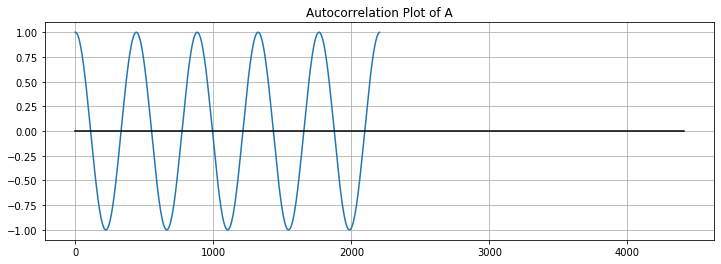

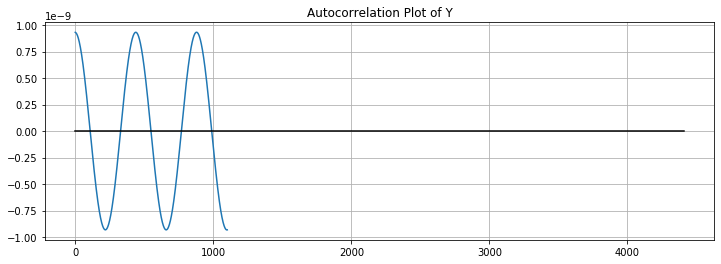

In [35]:
X =  makeSignal([(100,1,0)],duration=0.1)

A = acorr(X, normalize = True)

plt.figure(figsize=(12,4))
plt.title("Autocorrelation Plot of A")
plt.plot(A)
plt.plot([0,len(X)],[0,0],color='k')
plt.grid()
plt.show()

Y = acorr(A, normalize = True)
plt.figure(figsize=(12,4))
plt.title("Autocorrelation Plot of Y")
plt.plot(Y)
plt.plot([0,len(X)],[0,0],color='k')
plt.grid()
plt.show()
# Your code here

##  Problem Two (Pitch Determination using Autocorrelation)

### Part (A) 

A common heuristic is to use the first peak that exceeds a given relative threshold, say 0.75.
(To get the threshold in absolute terms, use `MAX_AMP * relative_threshold`.) 

For the next example,
scan through the peaks returned by the function, and find the first $t$ value for a peak where $A[t] >$ `relative_threshold`. This
is the period of the fundamental frequency F0.

Complete the following template. 

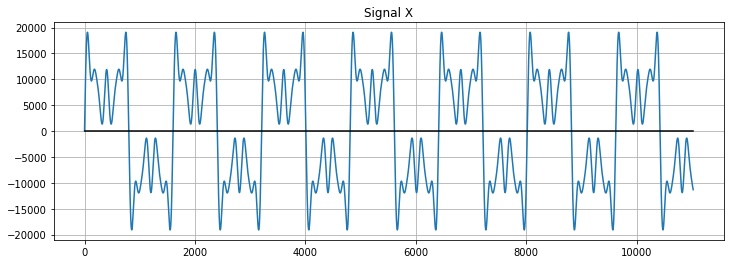

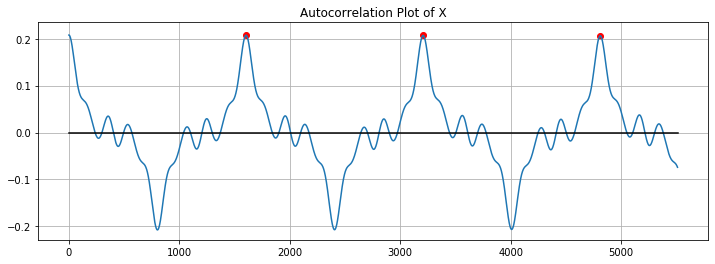

Detected Peaks:     [1604 3207 4811]
Detected Period:     1604.0
Actual Period:       1603.6363636363637
Detected Freq:       27.49376558603491
Actual Freq:         27.5
Percent Error:       0.00022670596236687082


In [110]:


def acorr_pitch(X,relative_threshold=0.75,display=True):
    
    
    (A, Xp, Yp) = acorr_plot(X)
    
   
    
    ret = 0
    
    for peak in Xp:
        if A[peak] > (relative_threshold * max( A )):
            period =  peak
            f0 = SR / period
            break
        else:
            period = 0
            f0 = 1
    # Your code here
    
    
    return (A,Px,Py,period,f0)
    
    
# test

notename = 'A0'

f = Freqs[notename]
S = makeSpectrum('clarinet',f)
X = makeSignal(S,duration=0.25)


(A,Px,Py,p1,f1) = acorr_pitch(X, .75, True)
print("Detected Peaks:    ", Px)
print("Detected Period:    ", SR/f1)
print("Actual Period:      ", SR/f)
print("Detected Freq:      ", f1)
print("Actual Freq:        ", f)
print("Percent Error:      ", (f-f1)/f)

### Improving the calculation using parabolic interpolation

When the period does not correspond to an integral number of samples,
then interpolation can be used to improve the results. For example,
in the previous example, we had the following detail around the first peak:

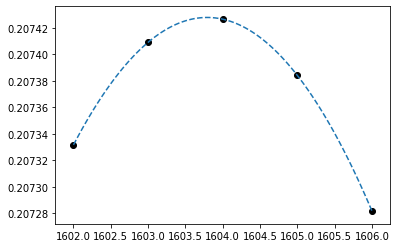

In [37]:
T = np.arange(1602,1607)
A1 = A[1602:1607]
f = interp1d(T,A1,kind='quadratic')
Tc = np.linspace(1602,1606,100)
Ac = [ f(x) for x in Tc ]
plt.plot(Tc,Ac,linestyle='--')
plt.scatter(T,A1,color='k')
plt.show()

The next cell shows
how this can be done using a standard formula. 

1603.7914461664268 0.20742774373795628


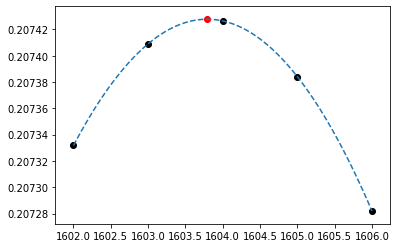

In [69]:

# Returns the (x,y) coordinates of the vertex of the parabola defined by points 
# (x1,y1), (x2,yx), (x3,y3) from the input lists:  xs = [x1,x2,x3], ys = [y1,y2,y3]

# http://stackoverflow.com/questions/717762/how-to-calculate-the-vertex-of-a-parabola-given-three-points"""


def parabolicInterpolationPeak(xs,ys):
#     print(xs,ys)
    [x1, x2, x3 ] = xs
    [y1, y2, y3 ] = ys
    denom = (x1 - x2) * (x1 - x3) * (x2 - x3)
    A     = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom
    B     = (x3*x3 * (y1 - y2) + x2*x2 * (y3 - y1) + x1*x1 * (y2 - y3)) / denom
    f = interp1d(xs,ys,kind='quadratic')
    x = -B / (2*A)
    return  (x, f(x))

# demonstration

T = np.arange(1602,1607)
A1 = A[1602:1607]
f = interp1d(T,A1,kind='quadratic')
Tc = np.linspace(1602,1606,100)
Ac = [ f(x) for x in Tc ]
plt.plot(Tc,Ac,linestyle='--')
plt.scatter(T,A1,color='k')
(px,py) = parabolicInterpolationPeak( [1603,1604,1605], [A[1603],A[1604],A[1605]] )
print(px,py)
py = f(px)
plt.scatter([px],[py],color='r')

plt.show()

### Part (B)

Complete the following template. The basic idea is to extract the first peak location (a sample number), then use the preceeding and following sample numbers to find the
precise vertex; the x-axis value of this vertex is a float which represents
the "fractional sample number" (not an integer) for the period. 

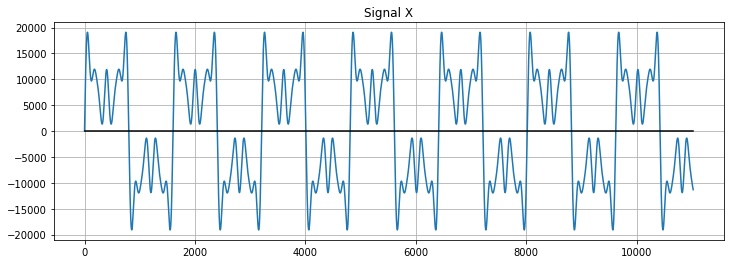

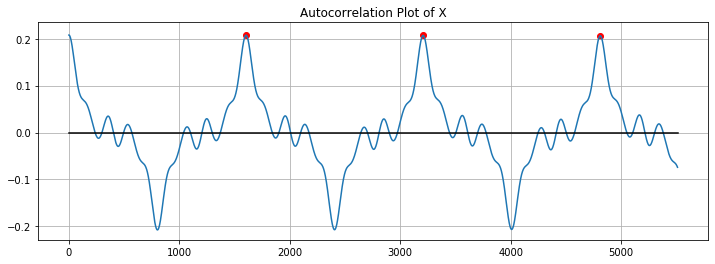

Detected Peaks:      [1604 3207 4811]
Detected Period:     1603.7914461664268
Actual Period:       1603.6363636363637
Detected Freq:       27.497340820349844
Actual Freq:         27.5
Percent Error:       9.669744182384028e-05


In [111]:
def acorr_pitch_interpolate(X,relative_threshold=0.75,display=True):
    
    
    (A, Xp, Yp) = acorr_plot(X)
    
    firstpeak = Xp[0]
    
    xs = [firstpeak - 1, firstpeak, firstpeak + 1]
    
    
    ys = [A[x] for x in xs]
    
    
    period = 0
    f0 = 0
    peak = parabolicInterpolationPeak(xs, ys)
    
    
    period = float(peak[0])
   
    f0 = SR / period
    
    
    return (A,Xp,Yp,period,f0)
    
    
# test

notename = 'A0'

f = Freqs[notename]
S = makeSpectrum('clarinet',f)
X = makeSignal(S,duration=0.25)


(A,Px,Py,p1,f1) = acorr_pitch_interpolate(X)
print("Detected Peaks:     ", Px)
print("Detected Period:    ", p1)
print("Actual Period:      ", SR/f)
print("Detected Freq:      ", f1)
print("Actual Freq:        ", f)
print("Percent Error:      ", (f-f1)/f)

## Problem Three (Efficient Pitch Determination)

Now let's write this in a more practical way. First, if the FIRST peak is
all we need, then you should be able to write it in a more efficient way,
where you don't need to analyze the entire sequence $accorK(X,k)$ for every $k$,
but stop when you get a value over the threshold. In other words, write this
so that in the loop for $k$, if you find a value over the threshold, break
out of the loop and return the value immediately (why keep going if
you have the answer?). 

Secondly, it is possible that no peak is found (what if you give it
a signal with silence?).  In this case, return a frequency of 0.0. 


### Part (A)

Rewrite the code above to use these ideas, and run it on the same example as
in the last problem.  You should use parabolic interpolation to improve the
result, as before.  Just return the frequency calculated. It should be the same
as last time. 

In [97]:
def get_pitch(X,relative_threshold=0.75):
    
    (A, Xp, Yp) = acorr_plot(X, display = False)
    if len(Xp) == 0: return 0.0


    firstpeak = Xp[0]
    
    xs = [firstpeak - 1, firstpeak, firstpeak + 1]
    
    
    ys = [A[x] for x in xs]
    
    
    period = 0
    f0 = 0
    peak = parabolicInterpolationPeak(xs, ys)
    
    period = float(peak[0])
   
    f0 = SR / period
    
    
    return f0    # Your code here

In [95]:
# test

notename = 'A0'

f = Freqs[notename]
S = makeSpectrum('clarinet',f)
X = makeSignal(S,duration=0.25)

f1 = get_pitch(X)
print("Detected Freq:      ", f1)
print("Actual Freq:        ", f)
print("Percent Error:      ", (f-f1)/f)

Detected Freq:       27.497340820349844
Actual Freq:         27.5
Percent Error:       9.669744182384028e-05


In [98]:
# test on silence

X = np.zeros(100)

f1 = get_pitch(X)
print("Detected Freq:      ", f1)

Detected Freq:       0.0


### Part (B): Fundamental Frequency of Some Real Signals

In this part we will try to determine the fundamental frequency of some actual real-world signals.

For each of the following determine the fundamental frequency, using `get_pitch`. 
Also print out the period in number of samples, and display the autocorrelation plot to check if the period seems reasonable. 

You may need to set the threshold appropriately, and to do that, you
might want to look at the autocorrelation plot!



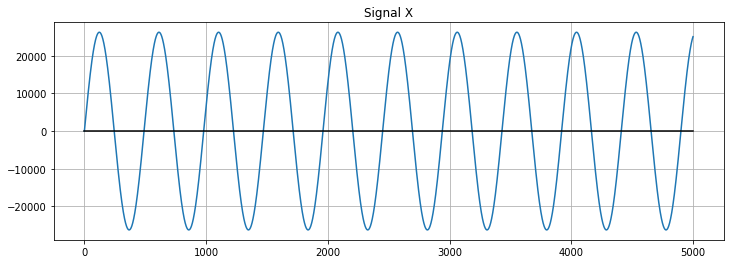

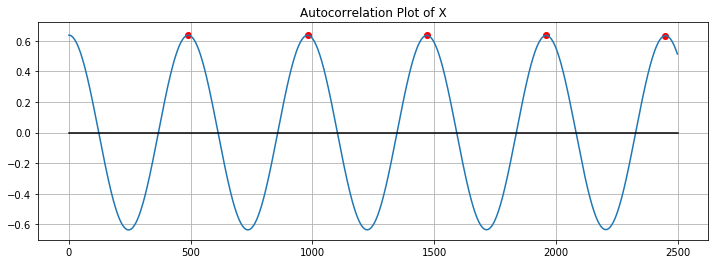

Detected Freq:    89.98021265741737 Hz.
Detected Period:  490.10775477829117 samples.


In [99]:
# (C)   

X2c1 = readWaveFile("MysterySignal01.wav")[:5000]

acorr_plot(X2c1)
f1 = get_pitch(X2c1)
print("Detected Freq:   ", f1, "Hz.")
print("Detected Period: ",SR/f1, "samples.")

The next file is of my 1959 Martin steel-string guitar, where I'm playing the low A string. Determine the fundamental frequency of the signal.  

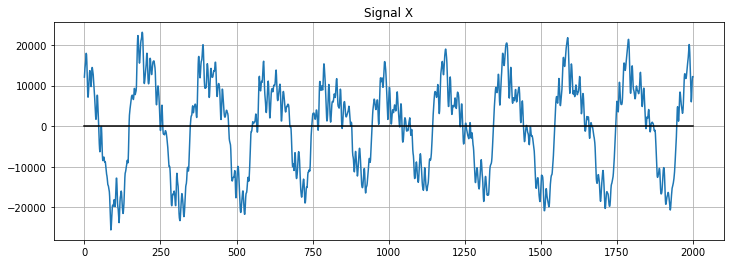

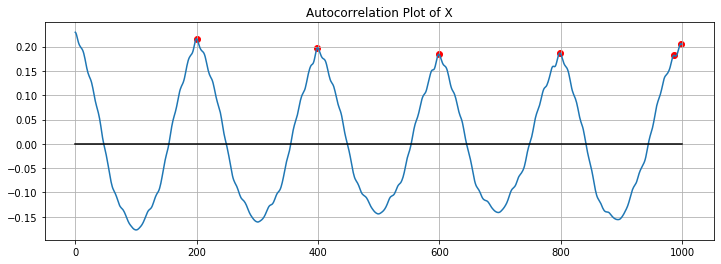

Detected Freq:    220.87650161335782 Hz.
Detected Period:  199.65908404868085 samples.


In [106]:
            
X2c2 = readWaveFile("SteelString.wav")[1000:3000]

# Your code here
(A, Xp, Yp) = acorr_plot(X2c2)
f1 = get_pitch(X2c2)
print("Detected Freq:   ", f1, "Hz.")
print("Detected Period: ",SR/f1, "samples.")

Next is a recording of a bell; you'll probably need to set a lower threshold for this. 

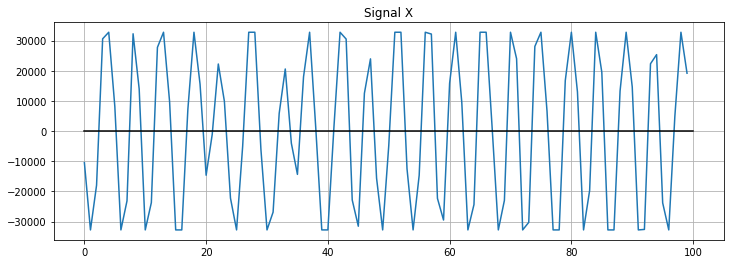

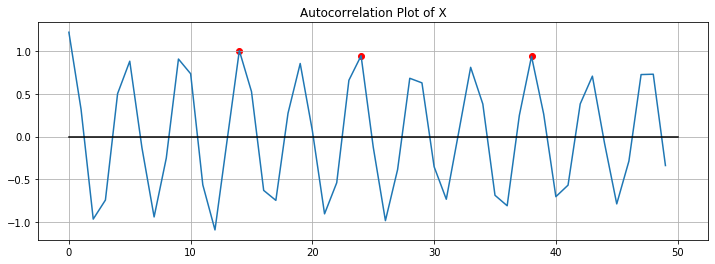

Detected Freq:    3108.867031804134 Hz.
Detected Period:  14.185231966774706 samples.


In [112]:
X2c3 = readWaveFile("bell.wav")[1100:1200]

# Your code here

acorr_plot(X2c3, relativeThreshold = .5)
f1 = get_pitch(X2c3)
print("Detected Freq:   ", f1, "Hz.")
print("Detected Period: ",SR/f1, "samples.")

This is a recording of the radio signal of the pulsar PSR B1937+21, the dead neutron star left after a supernova, 
and which has the mass of about our sun but the size of Boston, rotating rapidly and emitting pulses of radiation. 
How fast is it rotating? Fast enough that the surface of the pulsar is moving at 1/7th the speed of light! And this is only the <i>second fastest</i> pulsar that has been observed! 

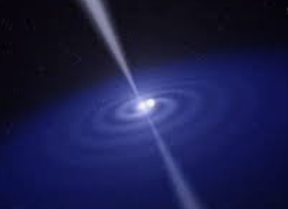

Run the code and find out its rotation speed in Hz.  Use a threshold of 0.9. 

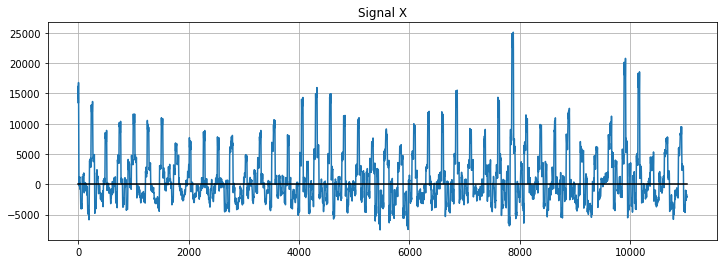

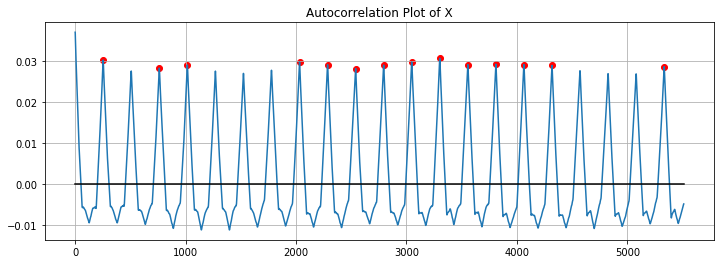

Detected Freq:    173.66302598961008 Hz.
Detected Period:  253.94006437869174 samples.


In [114]:
# (D)

X2c4 = readWaveFile("pulsar.wav")[:11025]
# Your code here

acorr_plot(X2c4, relativeThreshold = .9)
f1 = get_pitch(X2c4)
print("Detected Freq:   ", f1, "Hz.")
print("Detected Period: ",SR/f1, "samples.")

## Problem Four (Pitch Tracking)

For this part, I would like you to use a sliding window algorithm to apply
`get_pitch` to successive windows of a real musical signal. 

I am leaving this one up to you in terms of details about how big to make
the windows, how much overlap, etc.  What you should produce is
a reasonable graph of the pitch of some simple signals. 


Apply it to the file `thelick.wav` and one other file of your choosing (make
it a real file, not a synthetic one that we made). You may want to only track
a part of the signal.  You may have to change the threshold to avoid
errors.  I got "octave errors" (right pitch class, wrong octave) when
I tried the `invention_01.wav` file, see if you can get a decent track for
some melody. 

Don't worry, this is hard, and would be a good project!


### Part (A)

0.05 seconds


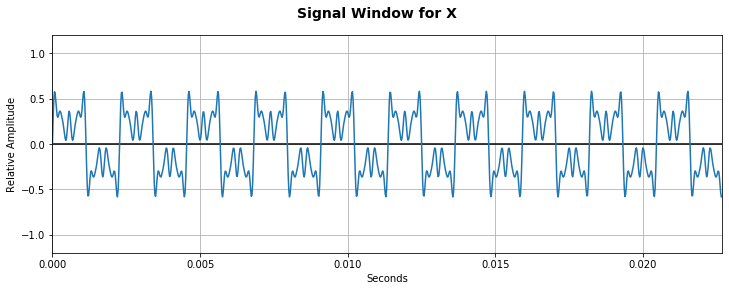

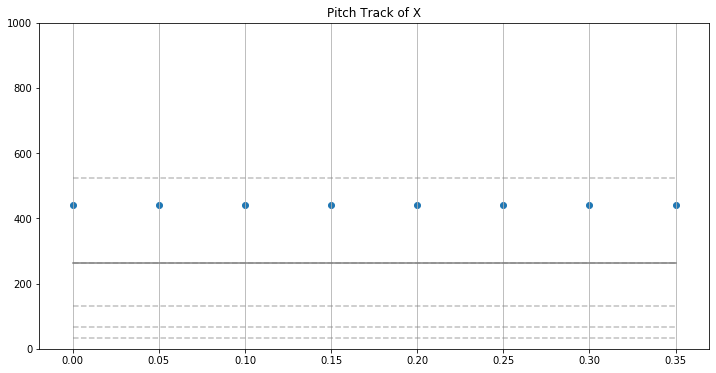

In [119]:
# Now let's do it with a sliding window. 

def get_pitch_plot(X, window_size=4410, overlap=0.5):
    
    left = 0             #starting left window bound
    right = window_size  #starting right window bound
    pitchtrack = np.array([])
    
    while right < len(X):   #loopsauce 
        window = X[left:right]   #create window
        pitch = get_pitch(window)  #get pitch from window
        pitchtrack = np.append(pitchtrack, pitch) #add to plot 
        right += int((1 - overlap) * window_size) #recreate bounds
        left = right - window_size                #.
        
    return pitchtrack
    
    
    
    

notename = 'A4'
D = 0.5
W = 4410        # window size
L = 0.5         # overlap

t = L * W / SR

print(t, 'seconds')

f = Freqs[notename]
S = makeSpectrum('clarinet',f)
X = makeSignal(S,duration = D)

displaySignal(X[:1000])

P = get_pitch_plot(X,W,L)
T = np.arange(0,len(P)*t,t)
freqLimit = 1000
plt.figure(figsize=(12,6))
plt.title("Pitch Track of X")
plt.ylim(0,freqLimit)
# draw note names for C's in all octaves
C1 = Freqs['C1']
C4 = Freqs['C4']
Cs = [ C1 * (2**k) for k in range(8) if (C1*(2**k)) <= freqLimit ]
for f in Cs:
    plt.plot( [0,T[-1]], [f,f], color='grey', alpha=0.5, linestyle='--' )
plt.plot( [0,T[-1]], [C4,C4], color='grey' )
plt.scatter(T,P)
plt.grid(axis='x')
plt.show()

### Part (B)

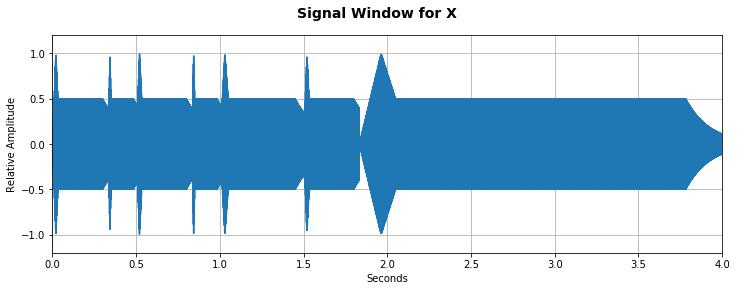

In [27]:
Xd1 = readWaveFile('thelick.wav')

displaySignal(Xd1)
Audio(Xd1,rate=SR)

0.05 seconds


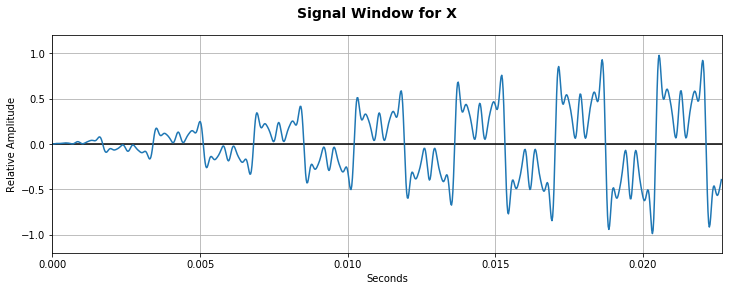

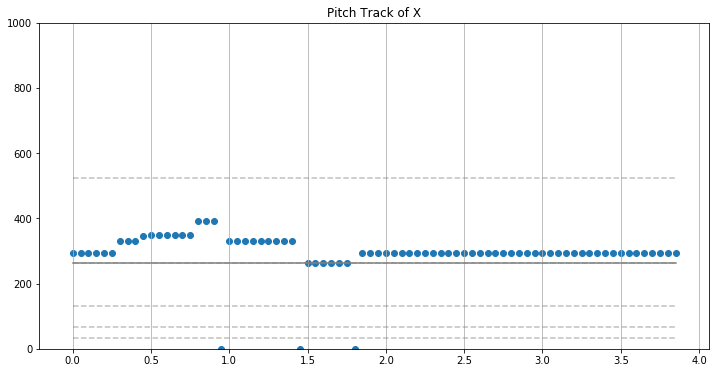

In [121]:
#  Calculate the pitch track for "The Lick"


# Your code here


notename = 'A4'
D = 0.5
W = 4410        # window size
L = 0.5         # overlap
t = L * W / SR

print(t, 'seconds')


XD2 = readWaveFile('thelick.wav')

displaySignal(XD2[:1000])

P = get_pitch_plot(XD2,W,L)
T = np.arange(0,len(P)*t,t)
freqLimit = 1000
plt.figure(figsize=(12,6))
plt.title("Pitch Track of XD2")
plt.ylim(0,freqLimit)
# draw note names for C's in all octaves
C1 = Freqs['C1']
C4 = Freqs['C4']
Cs = [ C1 * (2**k) for k in range(8) if (C1*(2**k)) <= freqLimit ]
for f in Cs:
    plt.plot( [0,T[-1]], [f,f], color='grey', alpha=0.5, linestyle='--' )
plt.plot( [0,T[-1]], [C4,C4], color='grey' )
plt.scatter(T,P)
plt.grid(axis='x')
plt.show()

### Part (C)

Do a pitch track of a file of your choosing. 

0.05 seconds


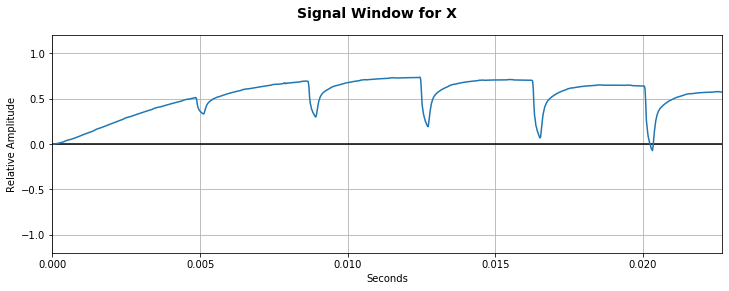

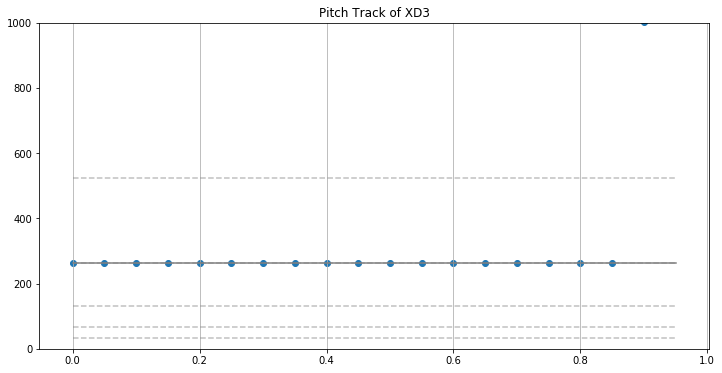

In [124]:
notename = 'A4'
D = 0.5
W = 4410        # window size
L = 0.5         # overlap
t = L * W / SR

print(t, 'seconds')


XD3 = readWaveFile('1980s-Casio-Trumpet-C5.wav')

displaySignal(XD3[:1000])

P = get_pitch_plot(XD3,W,L)
T = np.arange(0,len(P)*t,t)
freqLimit = 1000
plt.figure(figsize=(12,6))
plt.title("Pitch Track of XD3")
plt.ylim(0,freqLimit)
# draw note names for C's in all octaves
C1 = Freqs['C1']
C4 = Freqs['C4']
Cs = [ C1 * (2**k) for k in range(8) if (C1*(2**k)) <= freqLimit ]
for f in Cs:
    plt.plot( [0,T[-1]], [f,f], color='grey', alpha=0.5, linestyle='--' )
plt.plot( [0,T[-1]], [C4,C4], color='grey' )
plt.scatter(T,P)
plt.grid(axis='x')
plt.show()

##  Multirate Sampling: The Simple Case

When you have a signal of $N$ samples, and want to expand it or contract it by interpolation to a signal with $M$ samples--where both $N$ and $M$ are integers--then you can use a relatively simple method (which you implemented in the last homework) which is described here, and demonstrated in the next cell. 


https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample

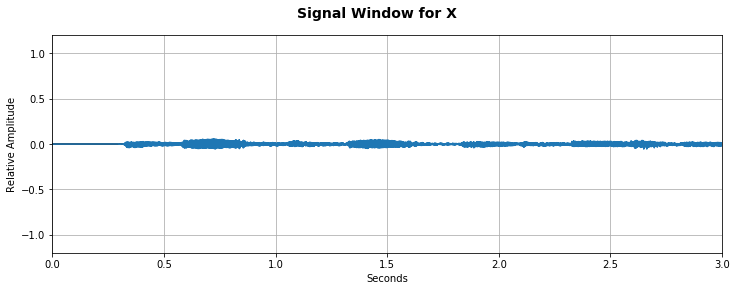

In [11]:
from scipy.signal import resample,resample_poly

# resample takes a signal X with N = len(X) samples and converts it into a signal
# with M samples, using Fourier Interpolation.

X = readWaveFile('invention.wav')

dur = 3.0

X1 = X[:int(dur*SR)]      # just first two seconds for the example

displaySignal(X1)
Audio(X1,rate=SR)

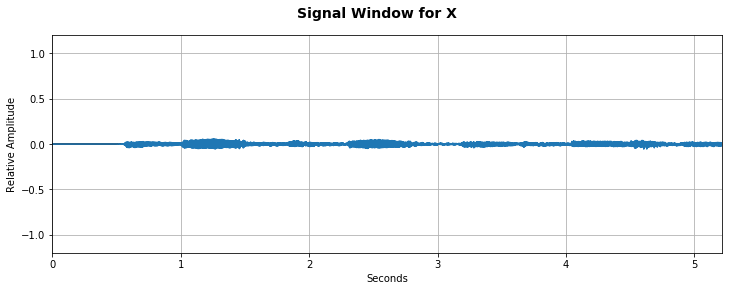

In [126]:
M = 230000

Y1 = resample(X1,M)

displaySignal(Y1)
Audio(Y1,rate=SR)

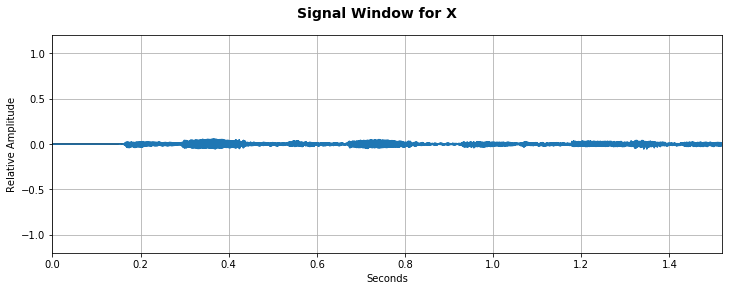

In [127]:
M = 67000

Y2 = resample(X1,M)

displaySignal(Y2)
Audio(Y2,rate=SR)

##  Multirate Sampling:  The Rational Factor Case

Often, however, you do not care that much about the exact number of
samples in the transformed signal, but care rather about the factor $P$ by which
you expand or contact time in the signal (e.g., $P=1.5$ means the total time
for the clip will be 1.5 times as long, and $P=0.5$ means it will be half as long,
and consequently twice as high in pitch). 

In this case, the trick is to express $P$ as a fraction $up\over down$, where `resample_poly` does the following:

- Upsamples by the factor $up$ by interpolation, so that the signal $X$ is $up$ times as long;
- Applies a filter to get rid of noise introduce by the upsampling; and
- Downsamples (or *decimates*) by the factor $down$, so the theoretical length of the
original signal would be 

$${len(X)\cdot up\over down} \text{ seconds,} $$

which will be fitted into $$\left\lceil {len(X)\cdot up\over down}\right\rceil \text{ samples.} $$

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample_poly.html#scipy.signal.resample_poly


There may be some *boundary conditions* at the end, because
the signal may not fit in a precise number of sample, which should only affect
a small number of samples and not matter with a sample rate of 44.1 KHz. See the example below. 

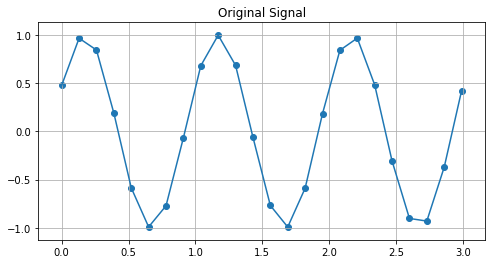

In [34]:
# A simple example showing how it works

X2 = [sin(2*np.pi*t+0.5) for t in np.arange(0,3,0.13)]

plt.figure(figsize=(8,4))
plt.title("Original Signal")
plt.plot(np.arange(0,3,0.13),X2)
plt.scatter(np.arange(0,3,0.13),X2)
plt.grid()
plt.show()

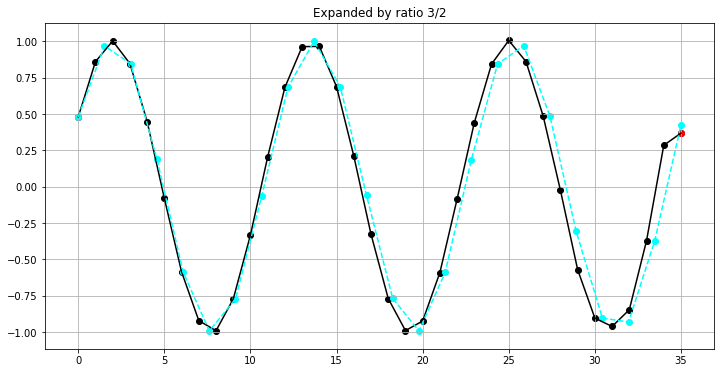

In [35]:
Y4 = resample_poly(X2,3,2)

plt.figure(figsize=(12,6))
plt.title("Expanded by ratio 3/2")
plt.plot(Y4,color='k')
plt.scatter(range(len(Y4)),Y4,color='k')
plt.plot(np.linspace(0,len(Y4)-1,len(X2)),X2,color='cyan',linestyle='--')
plt.scatter(np.linspace(0,len(Y4)-1,len(X2)),X2,color='cyan')
plt.scatter([len(Y4)-1],[Y4[len(Y4)-1]],color='r')
plt.grid()
plt.show()

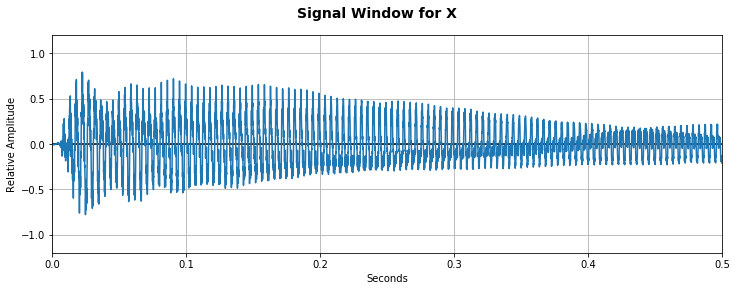

In [128]:
# Get first half second of guitar signal
Xguitar = (readWaveFile('SteelString.wav'))[:22050]
N = len(Xguitar)
dur = N/SR

displaySignal(Xguitar)
Audio(Xguitar,rate=SR)

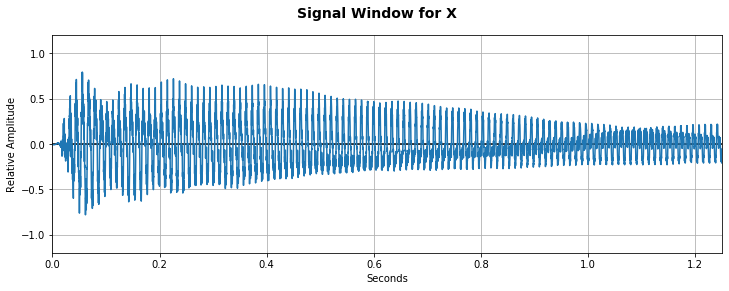

In [129]:
# Resample at 5/2, so slowed down by 2.5 (2.5x as long)

Y5 = resample_poly(Xguitar,5,2)
displaySignal(Y5)
Audio(Y5,rate=SR)

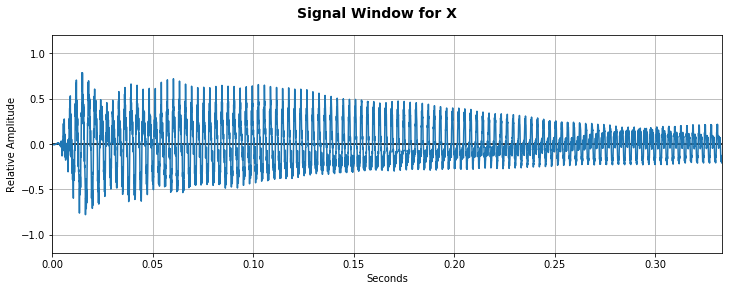

In [130]:
# Resample at 2/3, so speeded up by 1.5 (length is 2/3 of previous)

Y6 = resample_poly(Xguitar,2,3)
displaySignal(Y6)
Audio(Y6,rate=SR)

For another solution to this problem, see the appendix. 

##  Problem Five (Phase Vocoder: Unlocking Pitch and Time)

Complete the following template to use the rational-factor method `interpolate_poly`
to stretch or shrink the time by a floating-point factor $P$. In other works,
we are going to approximate the inefficient case with a more efficient case,
at the risk of being slightly off (since $P$ has to be presented as a numerator
and denominator). This is generally not a problem, unless we are using
this method for sliding windows, in which case the phase will be a little off. 


### Part (A) (Time Stretching by Interpolation)

In [5]:
from fractions import Fraction

# Convert a float factor P to a fraction N/M which is as close as possible to P.  
# You may assume that P has at most 1 significant digit after the decimal point

def timeStretch(X,P):
    frac = Fraction.from_float(P).limit_denominator()
    retX = resample_poly(X, frac.numerator, frac.denominator)
    return retX     # Your code here
    
# Test it on the following example    

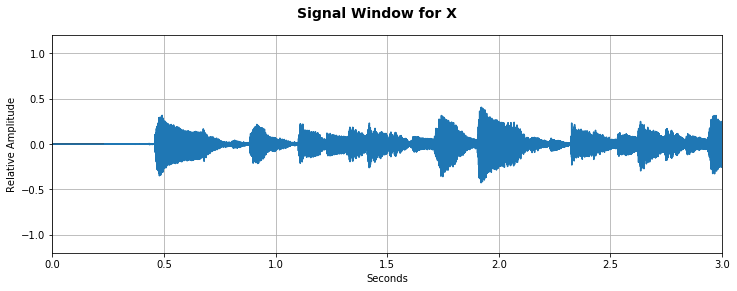

In [8]:
# Example to use
Tigran = readWaveFile("Tigran_Hamasyan_01.wav")

TigranShort = Tigran[:SR*3]
displaySignal(TigranShort)
Audio(TigranShort,rate=SR)

Now apply it to TigranShort and stretch the time by a factor of 2.3. 

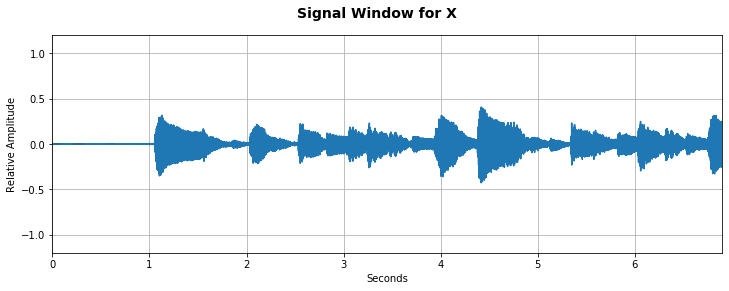

In [152]:
# Solution
newTigranShort = timeStretch(TigranShort, 2.3)
displaySignal(newTigranShort)
Audio(newTigranShort, rate = SR)

### Part (B) (Phase Vocoder)

The following is an almost-complete version of the phase vocoder; 
right now, it is another way to stretch time, but WITHOUT changing the
frequencies.

In order to change the pitch without changing the time, you would
use the phase vocoder to stretch/shrink the time, then do the
reverse with the timeStretch algorithm to shrink/stretch it back,
thereby changing the pitch. 

All you need
to do is to insert your time stretch algorithm at the end, and apply it
only when the mode is 'pitch' (for 'time' the vocoder is already doing time
modification). 

Test your code on the examples at the end. 

In [6]:


# P is increase factor:  for time mode, P is expansion factor for duration
# for pitch, P indicates increase/decrease in pitch, e.g., P = 2 gives octave higher
# mode is 'time or 'pitch' (default is time)

def pitchStretchUnlocked(X, P, mode='time'):

    N = 2048       # window size for FFT
    H = N//4       # skip size -- how far the window advances at each step
    
    tscale = 1.0/P

    # signal blocks for processing and output
    phi  = np.zeros(N)
    out = np.zeros(N, dtype=complex)
    Y = np.zeros(int(len(X)/tscale+N))

    # max input amp, window
    amp = max(X)
    win = signal.windows.hann(N)

    # p is beginning of window
    p = 0
    pp = 0


    while(p < len(X)-(N+H)):
        #    print(str(p) + "\t" + str(pp))

        # take the spectra of two consecutive windows
        spec1 =  np.fft.fft(win*X[p:p+N])
        spec2 =  np.fft.fft(win*X[p+H:p+N+H])

        # take their phase difference and integrate
        phi += (np.angle(spec2) - np.angle(spec1))
    
        # bring the phase back to between pi and -pi
        for i in range(len(phi)):
            while(phi[i] < -pi): 
                phi[i] += 2*pi
            while(phi[i] >= pi): 
                phi[i] -= 2*pi
                
            out.real, out.imag = cos(phi), sin(phi)
    
        # inverse FFT and overlap-add
        Y[pp:pp+N] += (win*np.fft.ifft(spec2*out)).real

    
        pp += H
        p += int(H*tscale)
    
    if mode == 'pitch':
        
        frac = Fraction.from_float(P).limit_denominator()
        
        Y = resample_poly(X, frac.numerator, frac.denominator)                          # Your code here

    return Y

### Part (C):  Examples

Just verify that your code works on the examples provided

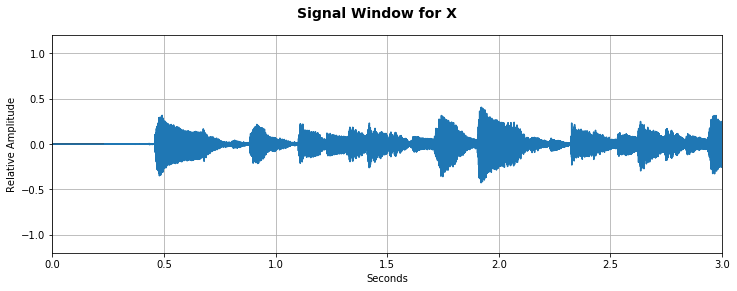

In [153]:
# Original signal
 
displaySignal(TigranShort)

Audio(TigranShort,rate=SR)

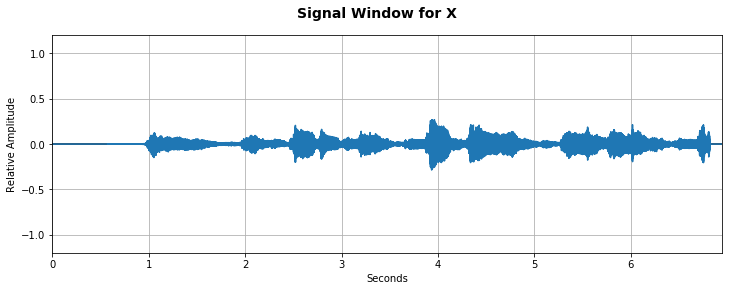

In [9]:
# Lengthen the time by a factor of 2.3 without changing the pitch. 

# Your code here
TS23 = pitchStretchUnlocked(TigranShort, 2.3, mode = 'time')

displaySignal(TS23)

Audio(TS23,rate=SR)

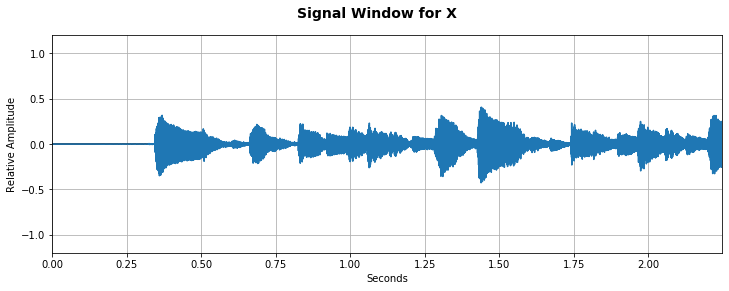

In [12]:
# Decrease the pitch by an octave and a fifth

P = Freqs['G3']/Freqs['C4']

# Your code here
TSN = pitchStretchUnlocked(TigranShort, P, mode = 'pitch')

displaySignal(TSN)

Audio(TSN,rate=SR)

### Part (D) Your turn!

Find some interesting snippet of music and change the pitch, and also the time, 
in a way that seems interesting to you.  

Warning:  You probably need to take a small piece, no more than a couple of seconds,
or else the algorithm will take a very long time.  Lots of room for efficiency improvements
in this one!

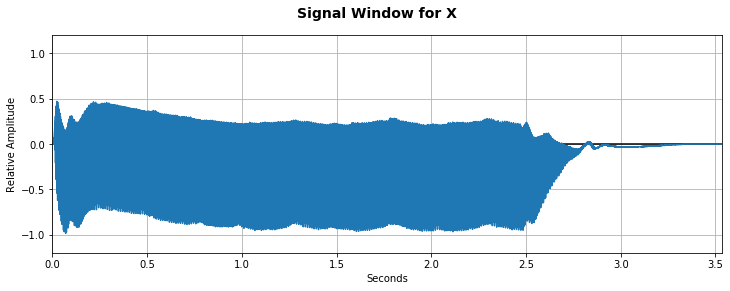

In [14]:
test = readWaveFile('1980s-Casio-Trumpet-C5.wav')


samp = pitchStretchUnlocked(test, 3.2, mode = 'time')

displaySignal(samp)

Audio(samp,rate=SR)

## Appendix:  Multirate Sampling: The floating-point case

In order to avoid having to deal with integral-length signals (i.e.,
the length has to be an integral number of samples), we can
use the FFT in a more subtle way to stretch or shrink the signal. 

Here is the basic idea:

- Your source signal $X$ has $N$ samples, hence having duration $D = {N\over SR}$ seconds, and you want to apply a time-stretch factor $P$ to obtain a signal of duration $P\ast D$ seconds: 
   - $P<1$ shrinks the time but increases the frequencies;
   - $P>1$ expands the time but lowers the frequencies; and
   - $P=1$ keeps the signal the same.
- `S = spectrumFFT(X)` produces a spectrum where the *window frequency* (the lowest non-zero frequency detected = the skip between frequencies in the spectrum) is $f = {SR\over N}$ Hz,
from frequency 0 up to the Nyquist limit:

 $$ S \quad =\quad  [ \quad (\,0\cdot f,\,a_0,\phi_0\,), \quad (\,1\cdot f,\,a_1,\,\phi_1\,), \quad \ldots, \quad (\,22050,\,a_{22050},\,\phi_{22050}\,)\quad ]$$


- Divide each of the frequencies by the factor $P$, and use the resulting spectrum to make a signal of length $P\ast D$ seconds; note that this may not fit precisely into an integral number of samples (as in all the preceeding approaches), but this would only make the very last sample inaccurate, which is usually irrelevant.  


What's the problem?  WAY inefficient!  A more sophisticated implementation might break the signal into windows
and process a piece at a time. 

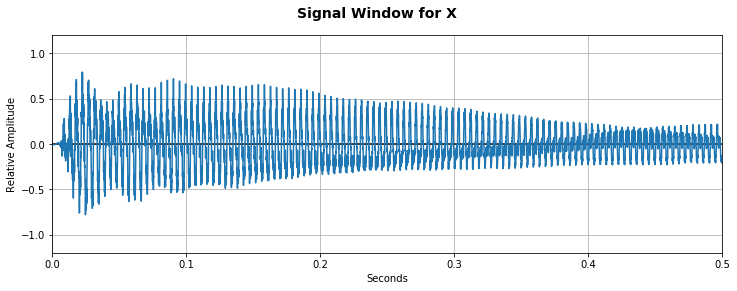

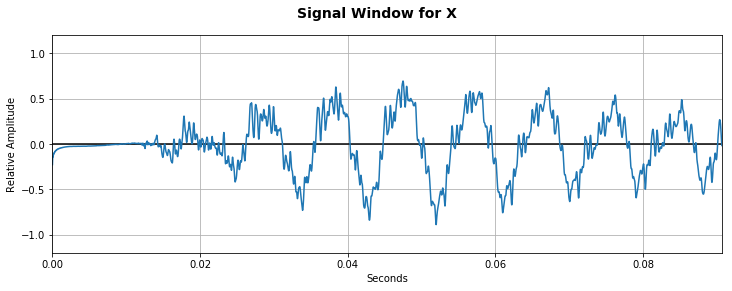

In [46]:
displaySignal(Xguitar)

P = 2.0

S = spectrumFFT(Xguitar)
SP = np.array( [ [ S[i][0]/P, S[i][1], S[i][2] ] for i in range(len(S))   ] )

X1 = makeSignal( SP, mode='absolute', duration=dur*P)
displaySignal(X1[:4000])
Audio(X1,rate=SR)

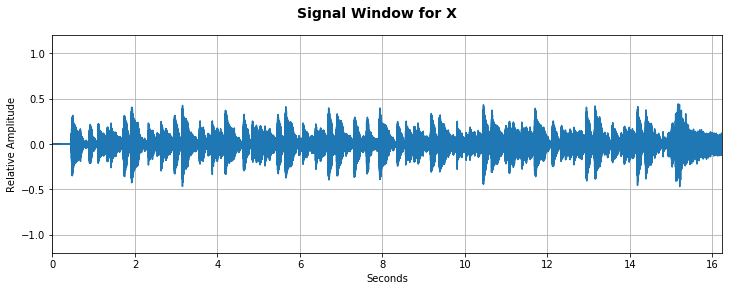

In [47]:
Tigran = readWaveFile("Tigran_Hamasyan_01.wav")

TigranShort = Tigran[:2*SR]       # just first two seconds

displaySignal(Tigran)
Audio(Tigran,rate=SR)